<a href="https://colab.research.google.com/github/crohan009/MBRL_thesis_2020/blob/master/FCNN_model_learning_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch===1.2.0 torchvision===0.4.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 748.9MB 21kB/s 
     |████████████████████████████████| 8.8MB 44.8MB/s 
  Found existing installation: torch 1.5.0+cu101
    Uninstalling torch-1.5.0+cu101:
      Successfully uninstalled torch-1.5.0+cu101
  Found existing installation: torchvision 0.6.0+cu101
    Uninstalling torchvision-0.6.0+cu101:
      Successfully uninstalled torchvision-0.6.0+cu101


In [2]:
# import gym
# import roboschool
import random
import os
# import argparse

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import r2_score
import numpy as np
import pandas as pd
from datetime import datetime
import time

print(torch.__version__)

from IPython.display import clear_output
import seaborn as sns; sns.set()
from matplotlib import pyplot as plt

%matplotlib inline
torch.autograd.set_detect_anomaly(True)

1.2.0


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Mount to G-drive

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [5]:
PATH = "/content/gdrive/My Drive/Thesis/"
os.listdir(os.path.join(PATH, "trajectory_datasets"))

['null_action_trajectory.npy',
 'random_action_trajectory.npy',
 'cosine_action_trajectory.npy']

Train and Test Datasets

In [6]:
class TrajectoryDataset(Dataset):

    def __init__(self, trajectory_tensor):
        self.trajectory = trajectory_tensor

    def __len__(self):
        return self.trajectory.shape[-1]

    def __getitem__(self, idx):
        return self.trajectory[:,:,idx]

In [7]:
cosine_action_trajectory   = np.load( os.path.join(PATH + "trajectory_datasets/cosine_action_trajectory.npy") )
print("cosine_action_trajectory.shape = {}".format(cosine_action_trajectory.shape))

cosine_action_trajectory.shape = (10, 1000, 1000)


In [8]:
train_test_split = 0.75
num_trajectories  = cosine_action_trajectory.shape[-1]
num_train_samples = train_test_split * num_trajectories

train_dataset  = TrajectoryDataset(cosine_action_trajectory[:,:,:int(num_train_samples)])
test_dataset   = TrajectoryDataset(cosine_action_trajectory[:,:,int(num_train_samples):-5])

pred_dataset = TrajectoryDataset(cosine_action_trajectory[:,:,-5:])

print("len(train_dataset) = {}".format(len(train_dataset)))
print("len(test_dataset) = {}".format(len(test_dataset)))
print("len(prediction_trajectory) = {}".format(len(pred_dataset)))

len(train_dataset) = 750
len(test_dataset) = 245
len(prediction_trajectory) = 5


Data Loaders

In [9]:
train_bsz = 50
test_bsz  = 50
pred_bsz  = 5

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=train_bsz, shuffle=True)
testloader  = torch.utils.data.DataLoader(test_dataset, batch_size=test_bsz, shuffle=True)
predloader  = torch.utils.data.DataLoader(pred_dataset, batch_size=pred_bsz, shuffle=False)

print("Train batches sizes:")
for traj in trainloader:
    print(traj.shape)
    break
print("Test batches:")
for traj in testloader:
    print(traj.shape)
    break
print("Prediction batches:")
for traj in predloader:
    print(traj.shape)
    break

Train batches sizes:
torch.Size([50, 10, 1000])
Test batches:
torch.Size([50, 10, 1000])
Prediction batches:
torch.Size([5, 10, 1000])


A decorator function to compute trianing time

In [10]:
def calculate_time(func):

    def inner1(*args, **kwargs):
        begin = time.time()
        func(*args, **kwargs)
        end = time.time()
        print("\n\n---------------------------------\nTotal time \
            taken in '{}' : {} seconds\n------------------------------\
            ---\n".format(func.__name__, end - begin))

    return inner1

Fully Connected Feed-forward Neural Network model

In [11]:
class FCNN_model1(torch.nn.Module):
    def __init__(self, inputSize, outputSize, dropout=False, device=None):
        super(FCNN_model1, self).__init__()
        self.linear1 = torch.nn.Linear(inputSize, inputSize)      # 10 -> 10
        self.batchnorm1 = nn.BatchNorm1d(inputSize)
        self.linear2 = torch.nn.Linear(inputSize, inputSize)      # 10 -> 10
        self.batchnorm2 = nn.BatchNorm1d(inputSize)
        self.linear3 = torch.nn.Linear(inputSize, inputSize)      # 10 -> 10
        self.batchnorm3 = nn.BatchNorm1d(inputSize)
        self.linear4 = torch.nn.Linear(inputSize, inputSize)      # 10 -> 10
        self.batchnorm4 = nn.BatchNorm1d(inputSize)
        self.linear5 = torch.nn.Linear(inputSize, outputSize)     #  9 -> 9
        self.batchnorm5 = nn.BatchNorm1d(outputSize)
        self.relu = nn.ReLU(inplace=False)
        self.dropout_25 = nn.Dropout(p=0.2)
        self.dropout_50 = nn.Dropout(p=0.5)
        self.do_dropout = dropout

        self.device = device
        self.now = datetime.now().strftime("%d-%m-%Y_%H.%M.%S")
        self.start_epoch = 1

    def forward(self, x):
        out = self.relu(self.batchnorm1(self.linear1(x)))
        out = self.relu(self.batchnorm2(self.linear2(out)))
        out = self.relu(self.batchnorm3(self.linear3(out)))
        if self.do_dropout:
            out = self.dropout_25(out)
        out = self.relu(self.batchnorm4(self.linear4(out)))
        if self.do_dropout:
            out = self.dropout_50(out)
        out = self.batchnorm5(self.linear5(out))
        return out

    def c2tt(self, x):
        #convert to torch tensor
        return torch.from_numpy(x).type(dtype='torch.FloatTensor')

    def plot(self, df, prediction_window_length, savefig=False, save_frequency=None, save_dir=None, title=None, xlabel='time step', ylabel='loss'):
        clear_output(True)
        # plt.close()
        plt.figure(figsize=(20,5))
        fig = sns.lineplot(data=df)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        if title:
            plt.title(title)
        if savefig:
            assert save_dir != None, "Must provide a save_dir if savefig=True."
            path = os.path.join(save_dir, "figures", self.now)
            if not os.path.exists(path):
                os.makedirs(path)
            plt.savefig(os.path.join(path, "/FCN_model1_{}_w{}_plot.png".format(ylabel, prediction_window_length)))
        plt.show(fig)

    def plot_states(self, actual_states, predicted_states, prediction_window_length, save_dir='', savefig=False):

        # print("actual_states.shape = {}".format(actual_states.shape))
        # print("predicted_states.shape = {}".format(predicted_states.shape))
        clear_output(True)
        # plt.close()
        plt.figure(num=None, figsize=(30, 18), dpi=45)
        
        num_states = int(actual_states.shape[1])
        state_vec = ['x', 'vx', 'pos_x(pole2)',
                    'cos(theta)', 'sin(theta)', 'theta_dot',
                    'cos(gamma)', 'sin(gamma)', 'gamma_dot']
        assert (num_states == len(state_vec) ), \
            "States insides actual_states/predicted_states do not match state_vec."
        
        for i in range(num_states):
            plt.subplot(5,2,i+1)
            df = pd.DataFrame(data=np.array([actual_states[:,i], predicted_states[:,i]]).T,
                              columns=["actual", "predicted"])
            fig = sns.lineplot(data=df)
            plt.xlabel("time step")
            plt.title("State{} - {}".format(i, state_vec[i]), fontsize=12)

        plt.subplots_adjust(top=0.95, bottom=0.01, left=0.02 , right=0.98 , hspace=0.25, wspace=0.05)
        plt.suptitle("Actual vs Predicted Robot states", fontsize=22)

        if savefig:
            assert save_dir != '', "Must provide a save_dir if savefig=True."
            path = os.path.join(save_dir, "figures", self.now)
            if not os.path.exists(path):
                os.makedirs(path)
            plt.savefig(os.path.join(path, "/FCN_model1_{}_w{}_plot.png".format("state_comparison", prediction_window_length) ))
        plt.show()

    @calculate_time
    def predict(self, predloader, prediction_window_length, save_pred_data=False, save_dir=None, total_pred_steps=100):
        print('Predicting with model...')

        self.eval()

        for idx, trajectory in enumerate(predloader, 1):

            print("trajectory.shape = {}".format(trajectory.shape))

            actual_states  = [trajectory[:, :-1, 0]]
            actual_actions = [trajectory[:, -1:, 0]]
            pred_states    = [trajectory[:, :-1, 0]]

            #Prediction iteration
            for i in range(1, total_pred_steps):
                next_state  =  trajectory[:, :-1, i]
                next_action =  trajectory[:, -1:, i]

                inputs = torch.cat( [pred_states[-1].float(), 
                                        actual_actions[-1].float()], dim=1)
                
                # print("actual_states[-1] = {}".format(actual_states[-1][0,:].cpu().numpy().flatten()))
                
                next_pred_state = pred_states[-1].float() + self( inputs.float() )

                actual_states.append(next_state)
                actual_actions.append(next_action)
                pred_states.append(next_pred_state)

            for i in range(len(actual_states)):
                actual_states[i] = actual_states[i].detach().cpu().numpy()
                pred_states[i]   = pred_states[i].detach().cpu().numpy()

            actual_states, pred_states = np.array(actual_states), np.array(pred_states)

            # print("actual_states.shape = {}".format(actual_states.shape))
            # print("pred_states.shape = {}".format(pred_states.shape))

            self.plot_states(actual_states[:,-1,:], pred_states[:,-1,:], prediction_window_length, save_dir=PATH, savefig=save_pred_data)

            if save_pred_data:
                assert save_dir != None, "Must provide a save_path if save_pred_data=True."
                path = os.path.join(save_dir, "pred_data_{}".format(self.now))
                if not os.path.exists(path):
                    os.makedirs(path)

                np.save(os.path.join(path, "actual_states_w{}".format(prediction_window_length)), actual_states[:,0,:])
                np.save(os.path.join(path, "pred_states{}".format(prediction_window_length)), pred_states[:,0,:])
            
            break

    def save_checkpoint(self, epoch, optimizer, save_dir=None):
        assert save_dir != None, "Must provide a save_dir"

        filename = 'model_checkpoint_epoch{}.pth.tar'.format(epoch)
        path = os.path.join(save_dir, "saved_model_weights_{}".format(self.now))
        if not os.path.exists(path):  
            os.makedirs(path)   

        with open( os.path.join(path, filename) , 'wb') as f: 
            torch.save({
            'epoch': epoch,
            'model_state_dict': self.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, f)
            print("Saving file: {}".format(filename)) 

    def load_from_checkpoint(self, abs_path, optimizer):

        if not os.path.exists(abs_path):
            print("Checkpoint file not found: {}\n".format(abs_path))

        with open(abs_path, 'rb') as f:
            print("Loading: {}".format(abs_path))
            
            checkpoint = torch.load(abs_path, map_location=self.device)
            self.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            self.start_epoch = checkpoint['epoch']

    @calculate_time
    def train_from_dataset(self, trainloader, testloader, prediction_window_length,
                        loss_criterion, optimizer, print_freq, num_epochs, save_freq):
        
        print('Training model...')

        loss_lst_train, rsq_lst_train   = [], []
        loss_lst_test, rsq_lst_test     = [], []

        for epoch in range(self.start_epoch, self.start_epoch + num_epochs):
            
            epoch_loss = 0
            epoch_rsq  = 0

            # Training iteration
            self.train()
            for idx, train_trajectories in enumerate(trainloader, 1):
                
                bsz = train_trajectories.shape[0]
                num_inputs = train_trajectories.shape[1]
                num_steps = train_trajectories.shape[2]

                optimizer.zero_grad()

                # Sliding the window along the selected training trajectory
                for i in range(num_steps-prediction_window_length):

                    actual_states_window  = [train_trajectories[:, :-1, i].to(self.device)]
                    actual_actions_window = [train_trajectories[:, -1:, i].to(self.device)]
                    pred_states_window    = [train_trajectories[:, :-1, i].to(self.device)]

                    window_loss = 0
                    window_rsq  = 0

                    for j in range(i+1, i+prediction_window_length):

                        next_state  =  train_trajectories[:, :-1, j].to(self.device)
                        next_action =  train_trajectories[:, -1:, j].to(self.device)
                        inputs = torch.cat( [pred_states_window[-1].float(), 
                                             actual_actions_window[-1].float()], dim=1)
                        # inputs = torch.cat( [pred_states_window[-1], 
                        #                      actual_actions_window[-1]], dim=1)
                        
                        next_pred_state = pred_states_window[-1].float() + self( inputs.float() )
                        # next_pred_state = torch.add(pred_states_window[-1], self(inputs) )
                        # next_pred_state = self( inputs.float() )
                        
                        actual_states_window.append(next_state)
                        actual_actions_window.append(next_action)
                        pred_states_window.append(next_pred_state)

                        # optimizer.zero_grad()
                        # loss = loss_criterion(next_state, next_pred_state)
                        loss = loss_criterion(next_state.float(), pred_states_window[-1].float())
                        loss.backward(retain_graph=True)
                        optimizer.step()
                        r2   = r2_score(next_pred_state.detach().cpu().numpy(),
                                    next_state.detach().cpu().numpy())
                        
                        window_loss += loss.item()
                        window_rsq += r2

                    window_loss /= prediction_window_length-1
                    window_rsq /= prediction_window_length-1 

                    epoch_loss += window_loss
                    epoch_rsq += window_rsq

            epoch_loss /= (num_steps - prediction_window_length)
            epoch_rsq  /= (num_steps - prediction_window_length)

            loss_lst_train.append(epoch_loss)
            rsq_lst_train.append(epoch_rsq)

            epoch_loss = 0
            epoch_rsq  = 0

            # Test iteration
            self.eval()
            for idx, test_trajectories in enumerate(testloader, 1):
                
                bsz = test_trajectories.shape[0]
                num_inputs = test_trajectories.shape[1]
                num_steps = test_trajectories.shape[2]

                # Sliding the window along the selected training trajectory
                for i in range(num_steps-prediction_window_length):

                    actual_states_window  = [test_trajectories[:, :-1, i].to(self.device)]
                    actual_actions_window = [test_trajectories[:, -1:, i].to(self.device)]
                    pred_states_window    = [test_trajectories[:, :-1, i].to(self.device)]

                    window_loss = 0
                    window_rsq  = 0

                    for j in range(i+1, i+prediction_window_length):

                        next_state  =  test_trajectories[:, :-1, j].to(self.device)
                        next_action =  test_trajectories[:, -1:, j].to(self.device)
                        inputs = torch.cat( [pred_states_window[-1].float(), 
                                             actual_actions_window[-1].float()], dim=1)
                        # inputs = torch.cat( [pred_states_window[-1], 
                        #                      actual_actions_window[-1]], dim=1)
                        
                        next_pred_state = pred_states_window[-1].float() + self( inputs.float() )
                        # next_pred_state = torch.add(pred_states_window[-1], self(inputs) )
                        # next_pred_state = self( inputs.float() )
                                            
                        actual_states_window.append(next_state)
                        actual_actions_window.append(next_action)
                        pred_states_window.append(next_pred_state)

                        # optimizer.zero_grad()
                        # loss = loss_criterion(next_state, next_pred_state)
                        loss = loss_criterion(next_state.float(), pred_states_window[-1].float())
                        # loss.backward(retain_graph=True)
                        # optimizer.step()
                        r2   = r2_score(next_pred_state.detach().cpu().numpy(),
                                    next_state.detach().cpu().numpy())
                        
                        window_loss += loss.item()
                        window_rsq += r2

                    window_loss /= prediction_window_length-1
                    window_rsq /= prediction_window_length-1 

                    epoch_loss += window_loss
                    epoch_rsq += window_rsq

            # epoch_loss /= (idx * (num_steps - prediction_window_length) )
            epoch_loss /= (num_steps - prediction_window_length)
            epoch_rsq  /= (num_steps - prediction_window_length)

            loss_lst_test.append(epoch_loss)
            rsq_lst_test.append(epoch_rsq)

            print("Epoch:{:2d} : train_loss: {:.3f} , test_loss: {:.3f} | train_rsq: {:.3f}, test_rsq: {:.3f}".format(epoch+1,
                                                                                                                      loss_lst_train[-1],
                                                                                                                      loss_lst_test[-1],
                                                                                                                      rsq_lst_train[-1],
                                                                                                                      rsq_lst_test[-1]))
            if epoch % save_freq == 0 :
                self.save_checkpoint(epoch=epoch, optimizer=optimizer, save_dir=PATH)
            
            self.plot(df= pd.DataFrame(data= np.array([loss_lst_train, loss_lst_test]).T,
                                    columns=["train loss", "test loss"]),
                    prediction_window_length = prediction_window_length,
                    savefig=False,
                    save_frequency=print_freq,
                    save_dir=PATH,
                    title="MSE-loss / Prediction window = {}".format(prediction_window_length),
                    xlabel="time steps",
                    ylabel='MSE loss')

Train the model

In [12]:
use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")
print("Device = ", device)

Device =  cuda


In [ ]:
num_states  = 9
num_actions = 1
dropout = True

model1 = FCNN_model1(inputSize=num_states+num_actions,
                        outputSize=num_states,
                        dropout=dropout,
                        device=device)
model1.float().to(device)

print(model1)


display_plots = False
display_states = False
prediction_window_length = 2
num_epochs = 50
print_freq = 1

loss_criterion = nn.MSELoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001)
optimizer = optim.Adam(model1.parameters(), lr=0.001)

# file_path = os.path.join(PATH, "saved_model_weights", "saved_model_weights_16-12-2019_19.26.41", 'model_checkpoint_epoch{}.pth.tar'.format(50))

# model1.load_from_checkpoint(abs_path=file_path, optimizer=optimizer)

FCNN_model1(
  (linear1): Linear(in_features=10, out_features=10, bias=True)
  (batchnorm1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=10, out_features=10, bias=True)
  (batchnorm2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear3): Linear(in_features=10, out_features=10, bias=True)
  (batchnorm3): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear4): Linear(in_features=10, out_features=10, bias=True)
  (batchnorm4): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear5): Linear(in_features=10, out_features=9, bias=True)
  (batchnorm5): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (dropout_25): Dropout(p=0.2, inplace=False)
  (dropout_50): Dropout(p=0.5, inplace=False)
)


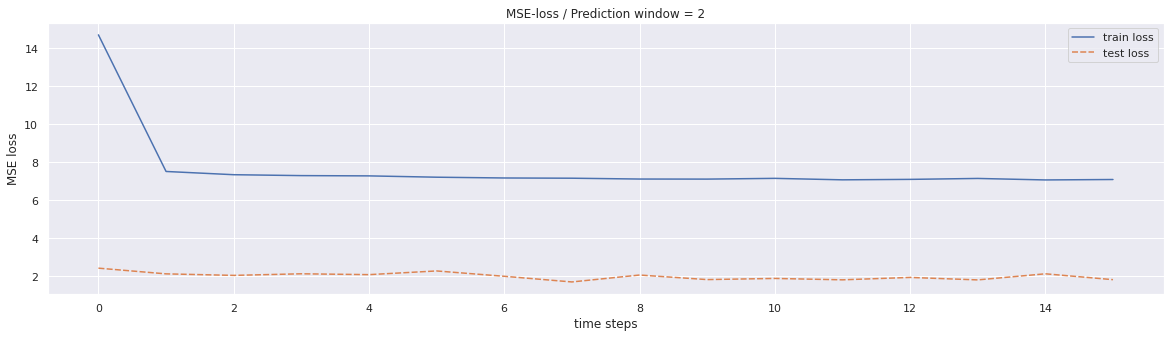

KeyboardInterrupt: ignored

In [ ]:
model1.train_from_dataset(trainloader = trainloader,
                         testloader = testloader,
                         prediction_window_length = prediction_window_length,
                         loss_criterion = loss_criterion,
                         optimizer = optimizer,
                         print_freq = print_freq,
                         num_epochs = num_epochs,
                         save_freq=10)

Predict on Trained model

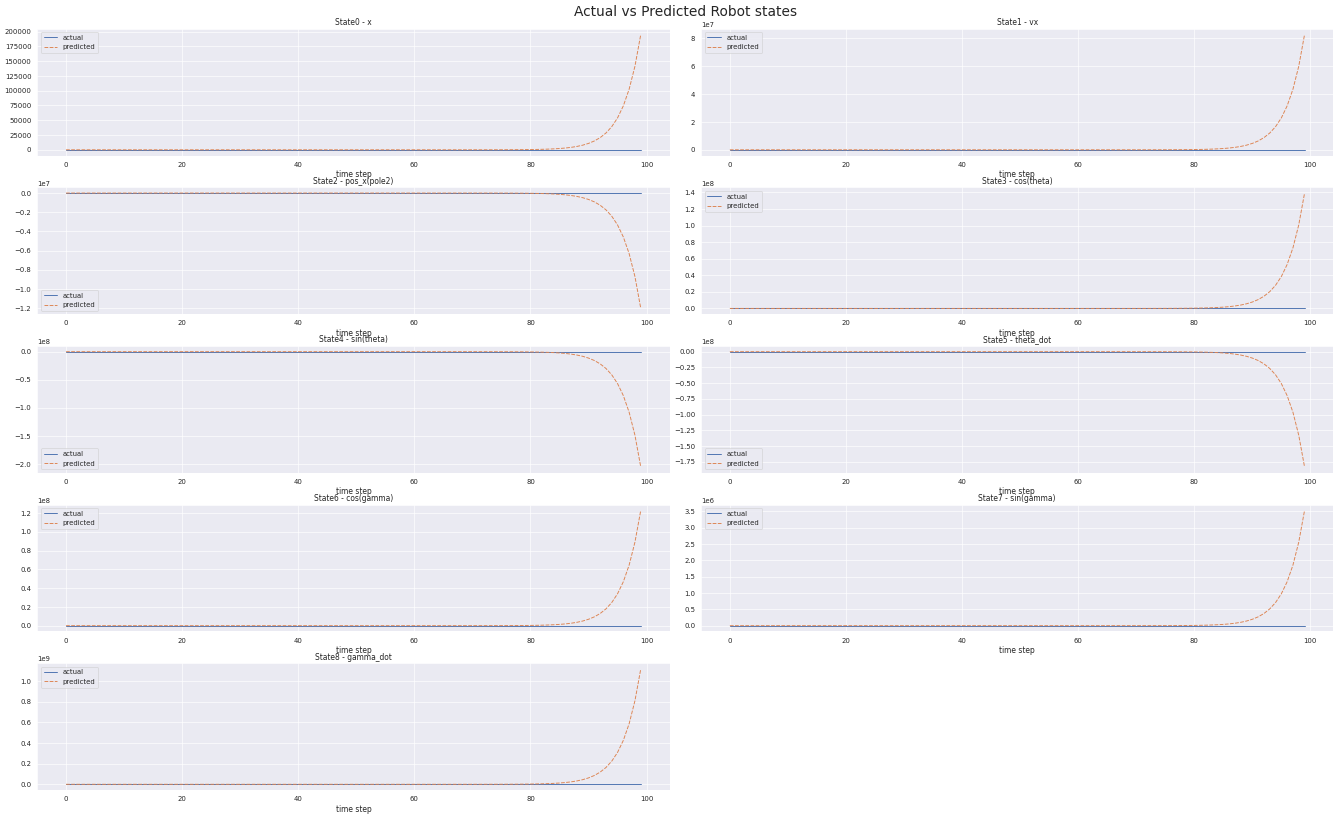



---------------------------------
Total time             taken in 'predict' : 5.179215669631958 seconds
------------------------------            ---



In [ ]:
prediction_window_length = 2

model1 = FCNN_model1(inputSize=num_states+num_actions,
                        outputSize=num_states,
                        dropout=dropout,
                        device=device)

model1.float().cpu()

file_path = os.path.join(PATH, "saved_model_weights", "saved_model_weights_02-06-2020_21.41.43", 'model_checkpoint_epoch{}.pth.tar'.format(60))

model1.load_from_checkpoint(abs_path=file_path, optimizer=optimizer)

model1.predict(predloader=predloader,
              prediction_window_length=prediction_window_length, 
              save_pred_data=True, 
              save_dir=os.path.join(PATH, "pred_data", "delta_state_pred_data") )

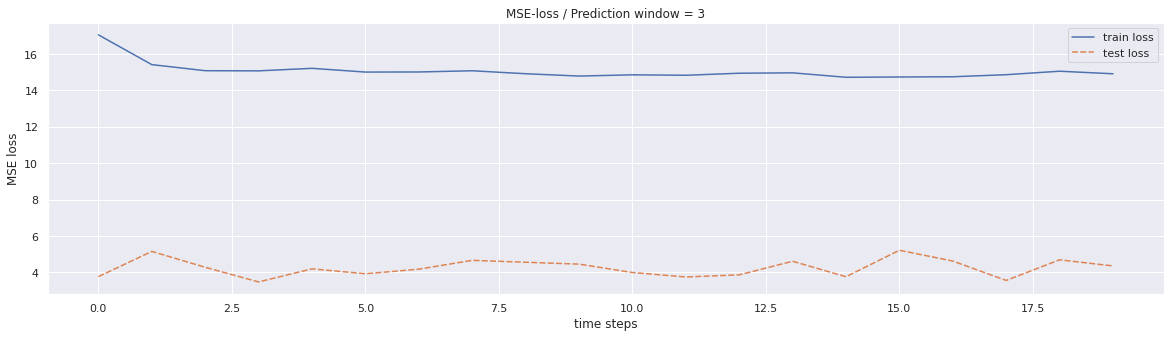



---------------------------------
Total time             taken in 'train_from_dataset' : 8263.326178312302 seconds
------------------------------            ---



In [ ]:
num_states  = 9
num_actions = 1
dropout = True

model2 = FCNN_model1(inputSize=num_states+num_actions,
                        outputSize=num_states,
                        dropout=dropout,
                        device=device)
model2.float().to(device)

# print(model2)

display_plots = False
display_states = False
prediction_window_length = 3
num_epochs = 20
print_freq = 1

loss_criterion = nn.MSELoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001)
optimizer = optim.Adam(model2.parameters(), lr=0.001)

# file_path = os.path.join(PATH, "saved_model_weights_16-12-2019_19.26.41", 'model_checkpoint_epoch{}.pth.tar'.format(50))

# model2.load_from_checkpoint(abs_path=file_path, optimizer=optimizer)

model2.train_from_dataset(trainloader = trainloader,
                         testloader = testloader,
                         prediction_window_length = prediction_window_length,
                         loss_criterion = loss_criterion,
                         optimizer = optimizer,
                         print_freq = print_freq,
                         num_epochs = num_epochs,
                         save_freq=1)

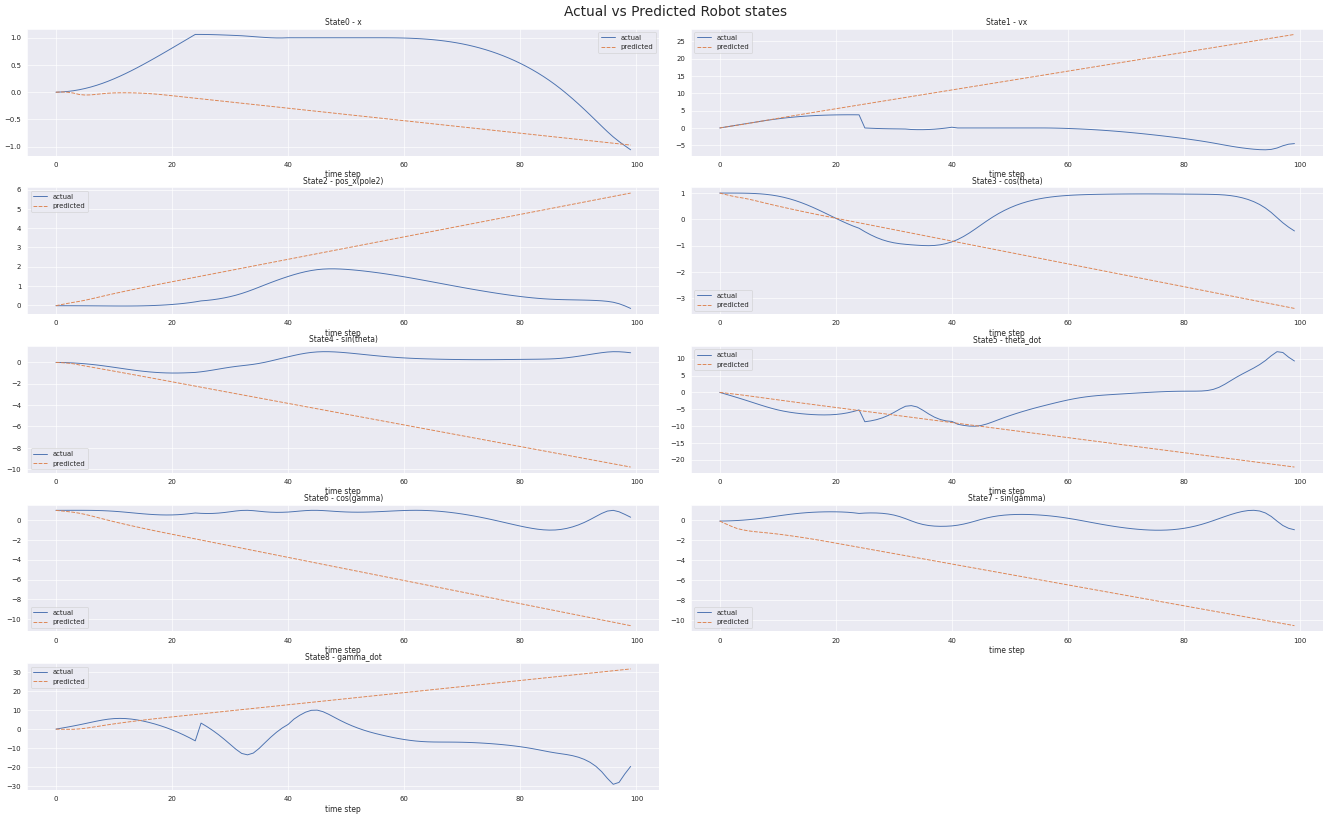



---------------------------------
Total time             taken in 'predict' : 3.4941718578338623 seconds
------------------------------            ---



In [ ]:
prediction_window_length = 3

model2 = FCNN_model1(inputSize=num_states+num_actions,
                        outputSize=num_states,
                        dropout=dropout,
                        device=device)

model2.float().cpu()

file_path = os.path.join(PATH, "saved_model_weights", "saved_model_weights_02-06-2020_22.40.37", 'model_checkpoint_epoch{}.pth.tar'.format(17))

model2.load_from_checkpoint(abs_path=file_path, optimizer=optimizer)

model2.predict(predloader=predloader,
              prediction_window_length=prediction_window_length, 
              save_pred_data=True, 
              save_dir=os.path.join(PATH, "pred_data", "delta_state_pred_data") )

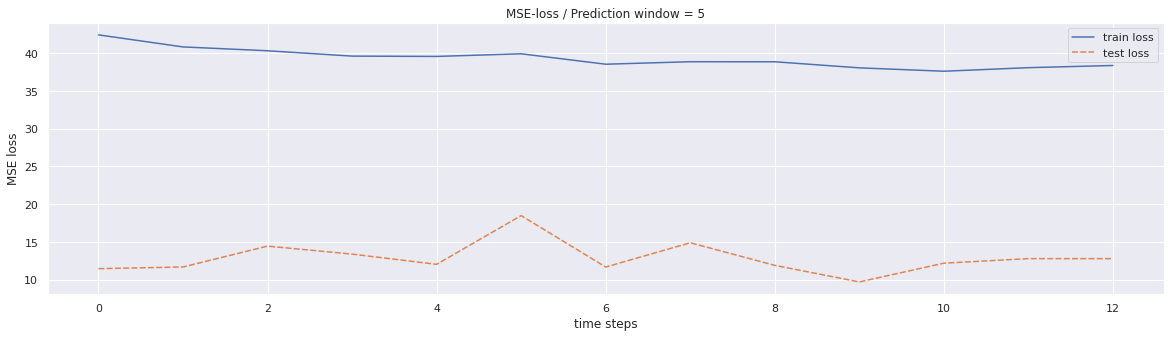

In [ ]:
num_states  = 9
num_actions = 1
dropout = True

model3 = FCNN_model1(inputSize=num_states+num_actions,
                        outputSize=num_states,
                        dropout=dropout,
                        device=device)
model3.float().to(device)

print(model3)


display_plots = False
display_states = False
prediction_window_length = 5
num_epochs = 20
print_freq = 1

loss_criterion = nn.MSELoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001)
optimizer = optim.Adam(model3.parameters(), lr=0.001)

model3.train_from_dataset(trainloader = trainloader,
                         testloader = testloader,
                         prediction_window_length = prediction_window_length,
                         loss_criterion = loss_criterion,
                         optimizer = optimizer,
                         print_freq = print_freq,
                         num_epochs = num_epochs,
                         save_freq=1)

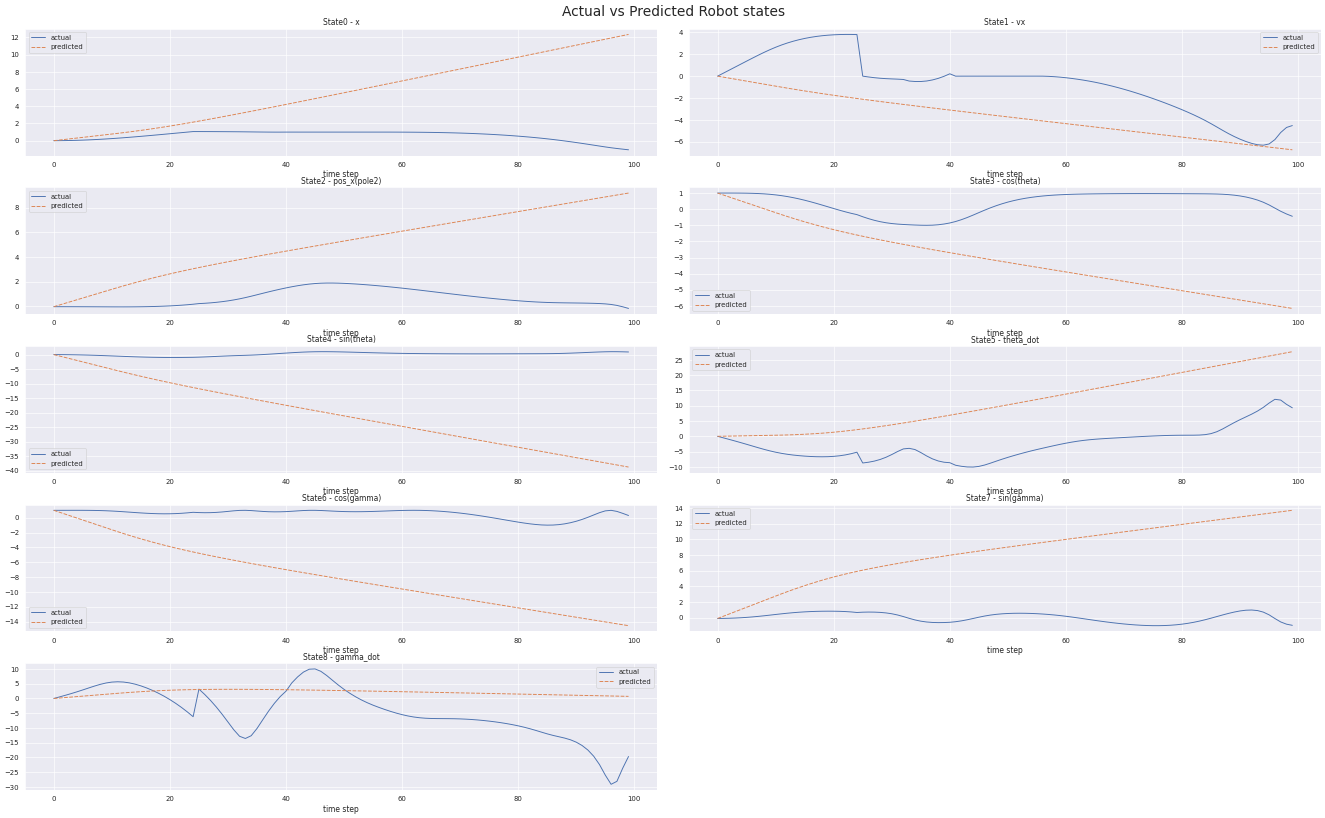



---------------------------------
Total time             taken in 'predict' : 3.6973698139190674 seconds
------------------------------            ---



In [ ]:
prediction_window_length = 5

model3 = FCNN_model1(inputSize=num_states+num_actions,
                        outputSize=num_states,
                        dropout=dropout,
                        device=device)

model3.float().cpu()

file_path = os.path.join(PATH, "saved_model_weights", "saved_model_weights_03-06-2020_00.58.25", 'model_checkpoint_epoch{}.pth.tar'.format(9))

model3.load_from_checkpoint(abs_path=file_path, optimizer=optimizer)

model3.predict(predloader=predloader,
              prediction_window_length=prediction_window_length, 
              save_pred_data=True, 
              save_dir=os.path.join(PATH, "pred_data", "delta_state_pred_data") )

In [13]:
num_states  = 9
num_actions = 1
dropout = True

model4 = FCNN_model1(inputSize=num_states+num_actions,
                        outputSize=num_states,
                        dropout=dropout,
                        device=device)
model4.float().to(device)

print(model4)


display_plots = False
display_states = False
prediction_window_length = 7
num_epochs = 10
print_freq = 1

loss_criterion = nn.MSELoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001)
optimizer = optim.Adam(model4.parameters(), lr=0.001)

# file_path = os.path.join(PATH, "saved_model_weights_16-12-2019_06.01.11", 'model_checkpoint_epoch{}.pth.tar'.format(10))

# model4.load_from_checkpoint(abs_path=file_path, optimizer=optimizer)


model4.train_from_dataset(trainloader = trainloader,
                         testloader = testloader,
                         prediction_window_length = prediction_window_length,
                         loss_criterion = loss_criterion,
                         optimizer = optimizer,
                         print_freq = print_freq,
                         num_epochs = num_epochs,
                         save_freq=5)

FCNN_model1(
  (linear1): Linear(in_features=10, out_features=10, bias=True)
  (batchnorm1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=10, out_features=10, bias=True)
  (batchnorm2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear3): Linear(in_features=10, out_features=10, bias=True)
  (batchnorm3): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear4): Linear(in_features=10, out_features=10, bias=True)
  (batchnorm4): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear5): Linear(in_features=10, out_features=9, bias=True)
  (batchnorm5): BatchNorm1d(9, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (dropout_25): Dropout(p=0.2, inplace=False)
  (dropout_50): Dropout(p=0.5, inplace=False)
)
Training model...


KeyboardInterrupt: ignored

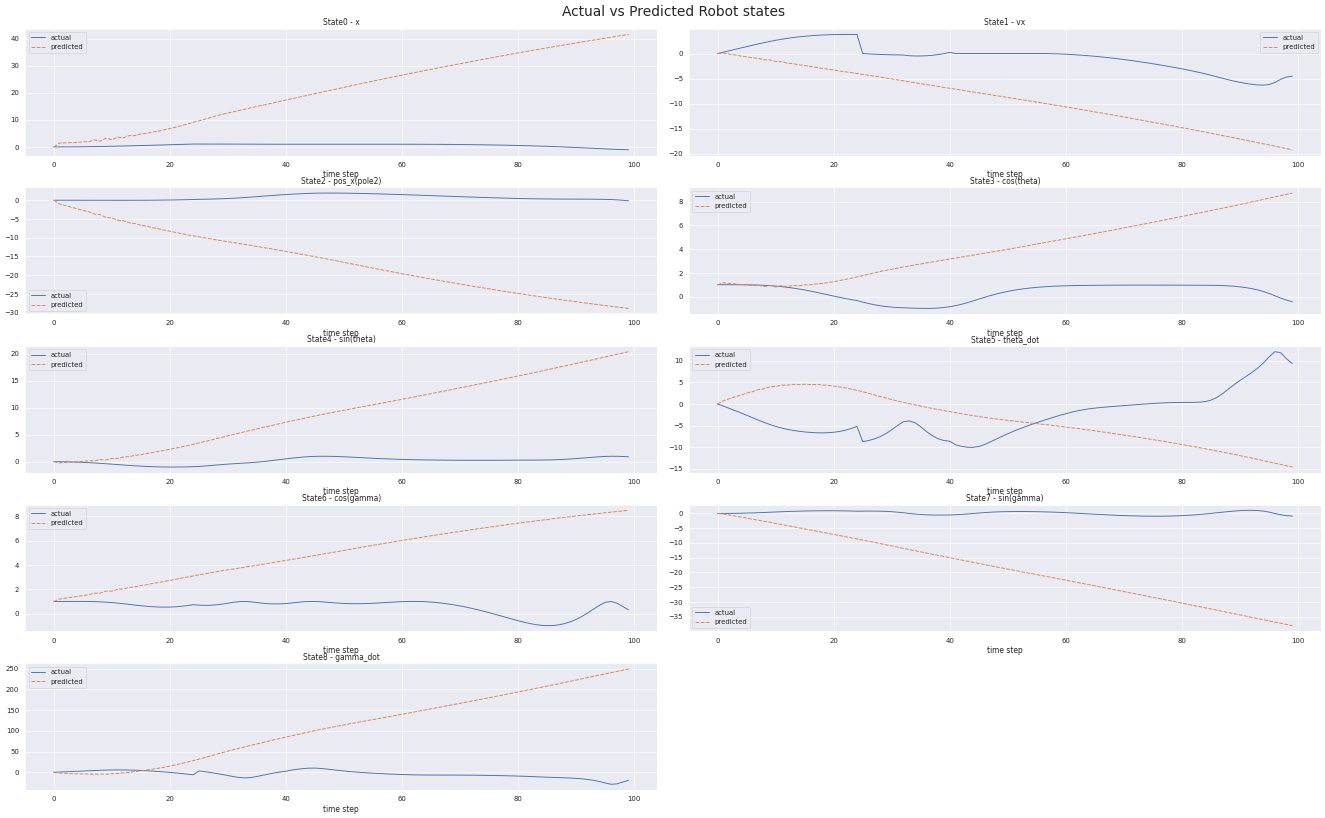



---------------------------------
Total time             taken in 'predict' : 3.5485332012176514 seconds
------------------------------            ---



In [ ]:
prediction_window_length = 7

model4 = FCNN_model1(inputSize=num_states+num_actions,
                        outputSize=num_states,
                        dropout=dropout,
                        device=device)

model4.float().cpu()

file_path = os.path.join(PATH, "saved_model_weights", "saved_model_weights_03-06-2020_09.33.30", 'model_checkpoint_epoch{}.pth.tar'.format(5))

model4.load_from_checkpoint(abs_path=file_path, optimizer=optimizer)

model4.predict(predloader=predloader,
              prediction_window_length=prediction_window_length, 
              save_pred_data=True, 
              save_dir=os.path.join(PATH, "pred_data", "delta_state_pred_data") )

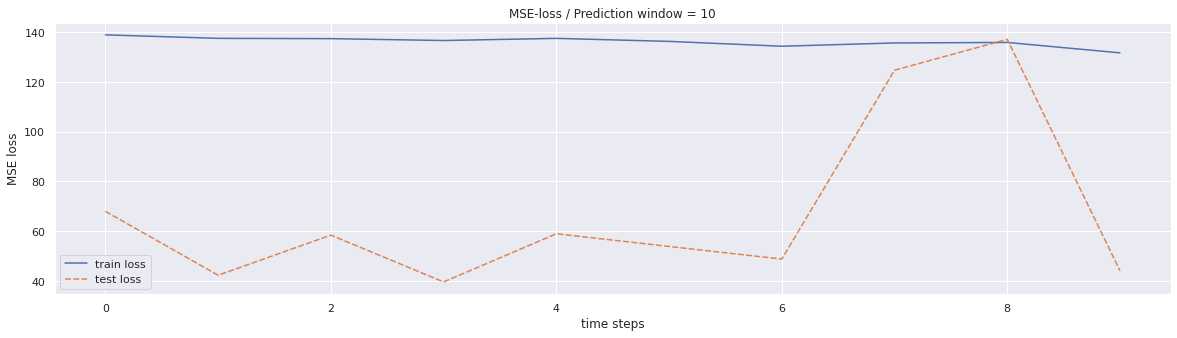



---------------------------------
Total time             taken in 'train_from_dataset' : 28462.335236787796 seconds
------------------------------            ---



In [ ]:
num_states  = 9
num_actions = 1
dropout = True

model5 = FCNN_model1(inputSize=num_states+num_actions,
                        outputSize=num_states,
                        dropout=dropout,
                        device=device)
model5.float().to(device)

# print(model5)


display_plots = False
display_states = False
prediction_window_length = 10
num_epochs = 10
print_freq = 1

loss_criterion = nn.MSELoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001)
optimizer = optim.Adam(model5.parameters(), lr=0.001)


# file_path = os.path.join(PATH, "saved_model_weights_16-12-2019_14.19.41", 'model_checkpoint_epoch{}.pth.tar'.format(10))

# model5.load_from_checkpoint(abs_path=file_path, optimizer=optimizer)

model5.train_from_dataset(trainloader = trainloader,
                         testloader = testloader,
                         prediction_window_length = prediction_window_length,
                         loss_criterion = loss_criterion,
                         optimizer = optimizer,
                         print_freq = print_freq,
                         num_epochs = num_epochs,
                         save_freq=1)

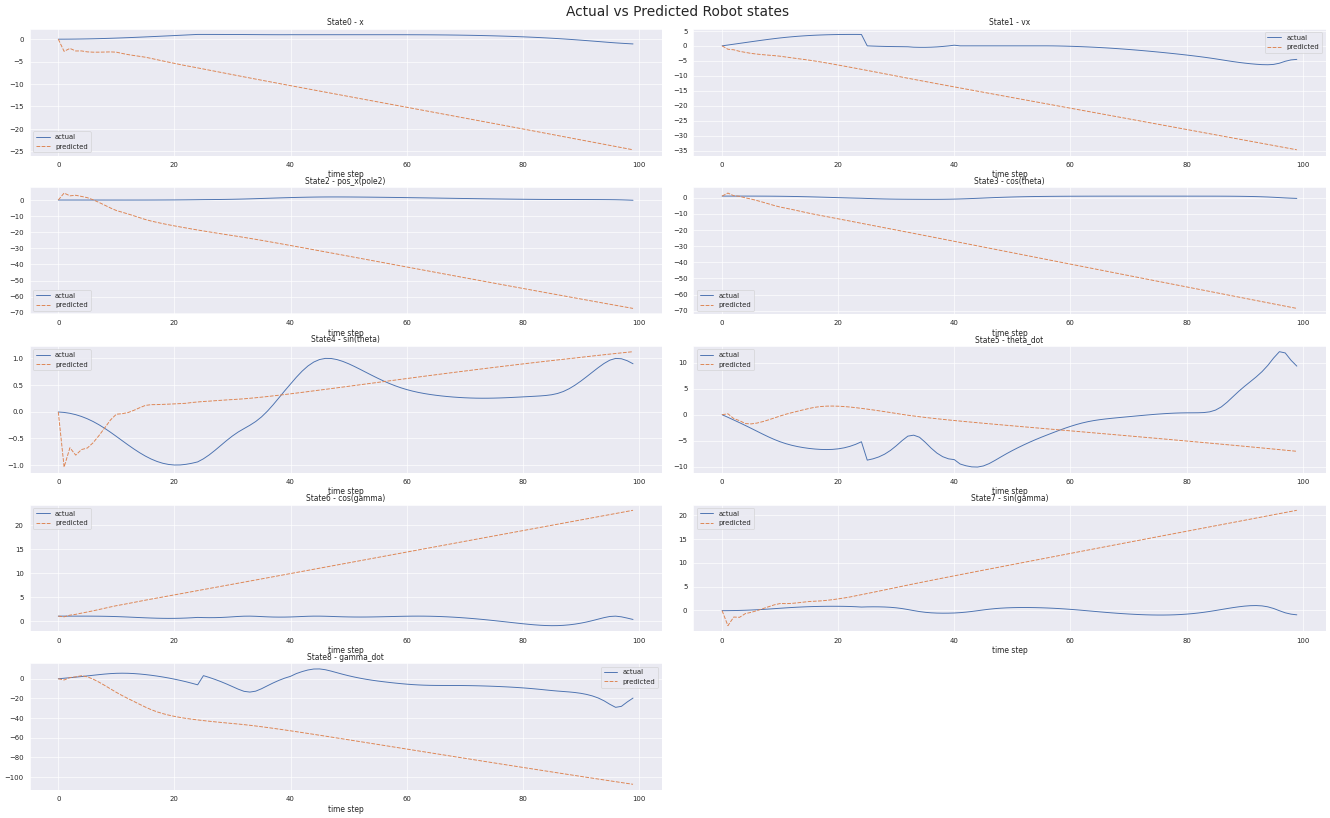



---------------------------------
Total time             taken in 'predict' : 3.851759433746338 seconds
------------------------------            ---



In [14]:
prediction_window_length = 10

model5 = FCNN_model1(inputSize=num_states+num_actions,
                        outputSize=num_states,
                        dropout=dropout,
                        device=device)
model5.float().cpu()

file_path = os.path.join(PATH, "saved_model_weights", "saved_model_weights_03-06-2020_22.42.45", 'model_checkpoint_epoch{}.pth.tar'.format(3))

model5.load_from_checkpoint(abs_path=file_path, optimizer=optimizer)

model5.predict(predloader=predloader,
              prediction_window_length=prediction_window_length, 
              save_pred_data=True, 
              save_dir=os.path.join(PATH, "pred_data", "delta_state_pred_data") )